In [237]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

In [471]:
class NeuralNetwork:
    def __init__(self, layers, activation, optimisation=None, beta=0.9, rms_decay = 0.9,  weights_initialize=None):
        """
        :param layers: A list specifying the number of neurons in each layer.
        :param activation: The activation function to use in the hidden layers.
        :param weights_initialize: Type of weight initialization (e.g., He, Xavier). If None -> random from uniform distribuiton U([0,1])
        :param optimisation: Type of the optimizer to be used (momentum/RMS/None). 
        :param beta: Beta parameter for momentum optimiser
        :param rms_decay: decay parameter for RMSProp
        """

        self.layers = layers
        self.weights = []
        self.bias = []
        self.beta = beta
        self.rms_decay = rms_decay
        self.velocity_weights =[]
        self.velocity_biases=[]
        self.rms_weights =[]
        self.rms_biases=[]

        if optimisation is None:
            print('No optimisation method')
            self.optimisation=None
        elif(optimisation=='momentum'):
            print('Selected optimisation method: Momentum')
            self.optimisation=optimisation
        elif(optimisation=='rms'):
            print('Selected optimisation method: RMSProp')
            self.optimisation=optimisation
        else:
            raise NameError("Chosen optimiser is not available, try 'momentum' or 'rms'")
        
        
       
   
        for i in range(len(layers)-1):
            if weights_initialize == "Xavier":
                std = np.sqrt(2 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            elif weights_initialize == "He":
                std = np.sqrt(2 / layers[i])
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            else:
                self.weights.append(np.random.uniform(-0.5, 0.5, size=(layers[i], layers[i+1])))

            self.velocity_weights.append(np.zeros_like(self.weights[i]))
            self.velocity_biases.append(np.zeros_like(np.random.uniform(-0.5, 0.5, size=(layers[i+1],))))
            

        self.bias = [np.random.uniform(-0.5, 0.5, size=(layers[i+1],)) for i in range(len(layers)-1)]
        
        self.velocity_weights = [np.zeros_like(w) for w in self.weights]
        self.velocity_biases = [np.zeros_like(b) for b in self.bias]

        self.rms_weights = [np.zeros_like(w) for w in self.weights]
        self.rms_biases = [np.zeros_like(b) for b in self.bias]

       

        activation_functions = {
            "sigmoid": self.sigmoid,
            "tanh": self.tanh,
            "relu": self.relu,
            "leaky_relu": self.leaky_relu
        }

        activation_functions_derivatives = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "relu":self.relu_derivative,
            "leaky_relu":self.leaky_relu

        }

        self.activation_function = activation_functions.get(activation)
        self.activation_function_derivative=activation_functions_derivatives.get(activation)

    #activation functions
    def sigmoid(self, x): 
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x): return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x): return np.tanh(x)
    def tanh_derivative(self, x): return 1-self.tanh(x)**2

    def relu(self,x):return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(int)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)

    def leaky_relu_derivative(self, x, alpha=0.01):
            return np.where(x > 0, 1, alpha)
    
   
    
    def forward(self, X):
        self.a = [X]
        self.z = [X]
        for i in range(len(self.weights)-1):
            z = np.dot(self.a[-1], self.weights[i]) + self.bias[i]
            self.z.append(z)
            a = self.activation_function(z)
            self.a.append(a)

        z = np.dot(self.a[-1], self.weights[-1]) + self.bias[-1]
        self.z.append(z)
        self.a.append(z)
        return self.a[-1]

    def backpropagate(self, X, y, learning_rate):
        m = X.shape[0]
        delta = [(self.forward(X) - y)] 
        
        #calculating errors 
        for i in range(len(self.weights)-1,0,-1):
            error = np.dot(delta[-1], self.weights[i].T) * self.activation_function_derivative(self.z[i])
            delta.append(error)
        delta = delta[::-1]

        epsilon = 1e-9
        #update weights according to chosen optimizer
        for i in range(len(self.weights)):
            grad_weights = np.dot(self.a[i].T, delta[i]) / m
            grad_bias = np.sum(delta[i], axis=0) / m

            if self.optimisation is None:
                self.weights[i] -= learning_rate*grad_weights
                self.bias[i] -= learning_rate*grad_bias

            elif self.optimisation=='momentum':
                self.velocity_weights[i] = self.beta*self.velocity_weights[i] + learning_rate*grad_weights
                self.velocity_biases[i] = self.beta*self.velocity_biases[i] + learning_rate*grad_bias
                self.weights[i] -= self.velocity_weights[i]
                self.bias[i] -= self.velocity_biases[i]
            elif self.optimisation=='rms':
                self.rms_weights[i] = self.rms_decay*self.rms_weights[i] + (1-self.rms_decay)*grad_weights**2
                self.rms_biases[i] = self.rms_decay*self.rms_biases[i] + (1- self.rms_decay)*grad_bias**2
                self.weights[i] -= learning_rate*grad_weights / (np.sqrt(self.rms_weights[i]) + epsilon)
                self.bias[i] -= learning_rate*grad_bias/ (np.sqrt(self.rms_biases[i])+ epsilon)
           
            


    def train(self, X_train, y_train, X_test, y_test, y_scaler, learning_rate, epochs,mse_threshold, batch_size=32, plot=True):
        train_losses = []
        test_losses=[]
        num_samples = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(X_batch)
                self.backpropagate(X_batch, y_batch, learning_rate)

         
        
            train_loss = self.MSE(X_train, y_train)
            train_losses.append(train_loss)
   
            if epoch % 100 == 0:
            
                Y_pred_denorm=y_scaler.inverse_transform(self.predict(X_test))
                mse = np.mean((Y_pred_denorm - y_test) ** 2)
                test_losses.append(mse)
                if plot:
                    print(f"Epoch {epoch}, Training Loss: {train_loss:.8f}, test MSE: {mse}")
                
                if mse<=mse_threshold:
                    print(f"TEST MSE ACHIEVED: {mse}, epoch{epoch}")
                    end_time = time.time()
                    print('TRAIN DURATION:', end_time-start_time) 
                    break
            
            if plot and epoch%10000 ==0:
                plt.scatter(X_test, y_test)
                plt.scatter(X_test, Y_pred_denorm)
                plt.title(f'MSE = {mse} dla epoki {epoch}')
                plt.show()

        end_time = time.time()
        print('TRAIN DURATION:', end_time-start_time) 
        plot_losses = test_losses[10:(len(test_losses)-1)]    
        plt.plot(plot_losses)
        plt.xlabel("Epoki / 100")
        plt.ylabel("MSE")
        plt.title("Wykres Test MSE podczas treningu od 1000 epoki")
        plt.show()

        
        plt.plot(train_losses)
        plt.xlabel("Epoki / 100")
        plt.ylabel("MSE na zbiorze znormalizowanym")
        plt.title("Wykres MSE podczas całego treningu")
        plt.show()
        
        

    def predict(self, X):
        return self.forward(X)
    
    def MSE(self, X, Y):
        return np.mean((self.predict(X) - Y) ** 2)

# Square large

In [ ]:
train_df = pd.read_csv('data/square-large-training.csv')
test_df = pd.read_csv('data/square-large-test.csv')

X_train, Y_train=train_df['x'].to_numpy().reshape(-1,1), train_df['y'].to_numpy().reshape(-1,1)
X_test, Y_test=test_df['x'].to_numpy().reshape(-1,1), test_df['y'].to_numpy().reshape(-1,1)

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_normalized = x_scaler.fit_transform(X_train.reshape(-1, 1))
Y_train_normalized = y_scaler.fit_transform(Y_train.reshape(-1, 1))

X_test_normalized = x_scaler.transform(X_test.reshape(-1,1))
Y_test_normalized = y_scaler.transform(Y_test.reshape(-1,1))

## Momentum

### Try 1 : MSE 1.4

Epoch 0, Training Loss: 0.05595313, test MSE: 13678.400591231395


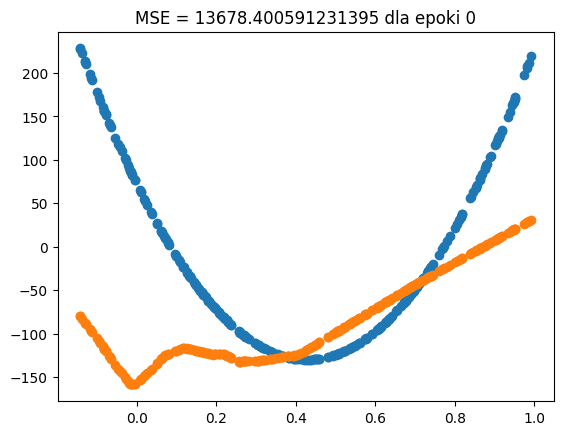

Epoch 100, Training Loss: 0.00146189, test MSE: 224.01162140839938
Epoch 200, Training Loss: 0.00031746, test MSE: 97.2654169300863
Epoch 300, Training Loss: 0.00017211, test MSE: 50.09829025291229
Epoch 400, Training Loss: 0.00011520, test MSE: 33.19942785925604
Epoch 500, Training Loss: 0.00009086, test MSE: 24.685674098127116
Epoch 600, Training Loss: 0.00007853, test MSE: 20.72272810139221
Epoch 700, Training Loss: 0.00006964, test MSE: 18.587297064094255
Epoch 800, Training Loss: 0.00006290, test MSE: 17.108044022253544
Epoch 900, Training Loss: 0.00005708, test MSE: 16.52662466431194
Epoch 1000, Training Loss: 0.00005200, test MSE: 15.822172706418288
Epoch 1100, Training Loss: 0.00004772, test MSE: 15.390943009181905
Epoch 1200, Training Loss: 0.00004409, test MSE: 15.0621166495661
Epoch 1300, Training Loss: 0.00004084, test MSE: 14.550971057032788
Epoch 1400, Training Loss: 0.00003803, test MSE: 13.925851437678599
Epoch 1500, Training Loss: 0.00003540, test MSE: 13.4447038375220

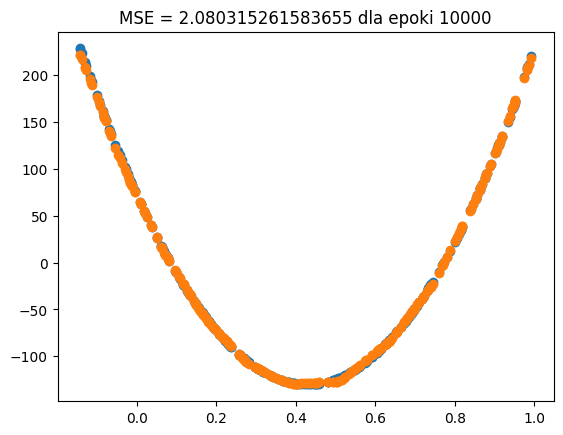

Epoch 10100, Training Loss: 0.00000706, test MSE: 2.063963990200443
Epoch 10200, Training Loss: 0.00000701, test MSE: 2.047836447050485
Epoch 10300, Training Loss: 0.00000697, test MSE: 2.0272922939263016
Epoch 10400, Training Loss: 0.00000694, test MSE: 2.0095085554352075
Epoch 10500, Training Loss: 0.00000690, test MSE: 1.9945504320426093
Epoch 10600, Training Loss: 0.00000686, test MSE: 1.9757616761918249
Epoch 10700, Training Loss: 0.00000682, test MSE: 1.961404656753306
Epoch 10800, Training Loss: 0.00000679, test MSE: 1.9483199118221144
Epoch 10900, Training Loss: 0.00000675, test MSE: 1.929768504724785
Epoch 11000, Training Loss: 0.00000672, test MSE: 1.9160054960898023
Epoch 11100, Training Loss: 0.00000668, test MSE: 1.9048892826379316
Epoch 11200, Training Loss: 0.00000665, test MSE: 1.8909275493805073
Epoch 11300, Training Loss: 0.00000662, test MSE: 1.873854918936033
Epoch 11400, Training Loss: 0.00000658, test MSE: 1.86095050010267
Epoch 11500, Training Loss: 0.00000655, t

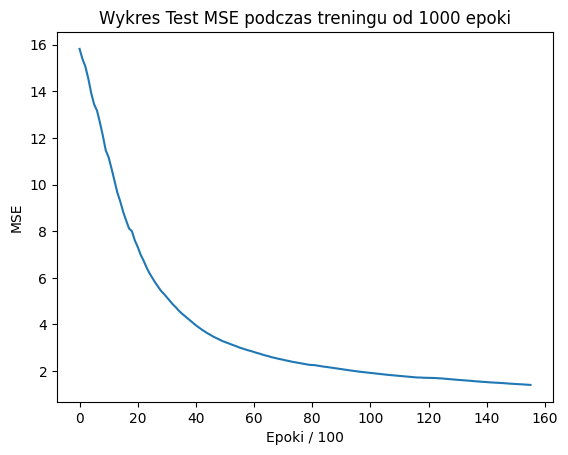

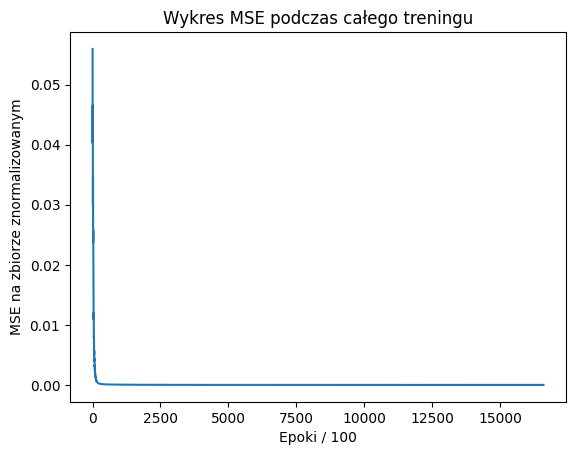

In [ ]:
nn = NeuralNetwork(layers=[1,20,25,1], activation='relu',optimisation='momentum', beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0011, batch_size=256, epochs=60000, mse_threshold=1.4)


### Try 2

Epoch 0, Training Loss: 0.07483764, test MSE: 10637.718837497176


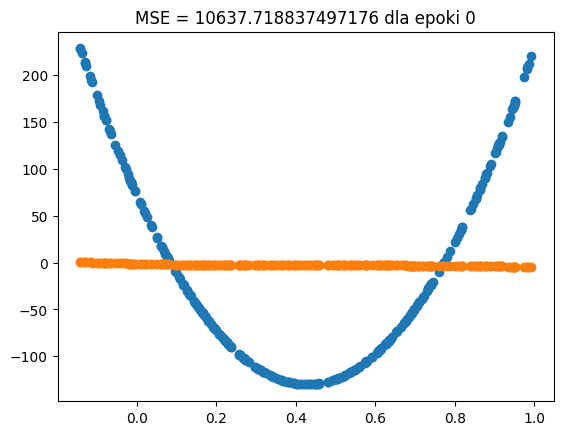

Epoch 100, Training Loss: 0.03578785, test MSE: 8894.539772351061
Epoch 200, Training Loss: 0.00028472, test MSE: 268.27110306034245
Epoch 300, Training Loss: 0.00018499, test MSE: 226.85994065288003
Epoch 400, Training Loss: 0.00015193, test MSE: 209.45526900089234
Epoch 500, Training Loss: 0.00012783, test MSE: 188.20633991323962
Epoch 600, Training Loss: 0.00010869, test MSE: 168.76485230378032
Epoch 700, Training Loss: 0.00009370, test MSE: 152.28795103748502
Epoch 800, Training Loss: 0.00008094, test MSE: 137.10183639811865
Epoch 900, Training Loss: 0.00007069, test MSE: 124.59324900557534
Epoch 1000, Training Loss: 0.00006195, test MSE: 113.4661639845974
Epoch 1100, Training Loss: 0.00005469, test MSE: 103.98281486006832
Epoch 1200, Training Loss: 0.00004855, test MSE: 95.77467087062405
Epoch 1300, Training Loss: 0.00004328, test MSE: 88.64540546822417
Epoch 1400, Training Loss: 0.00003888, test MSE: 82.39719829221394
Epoch 1500, Training Loss: 0.00003484, test MSE: 76.7486218280

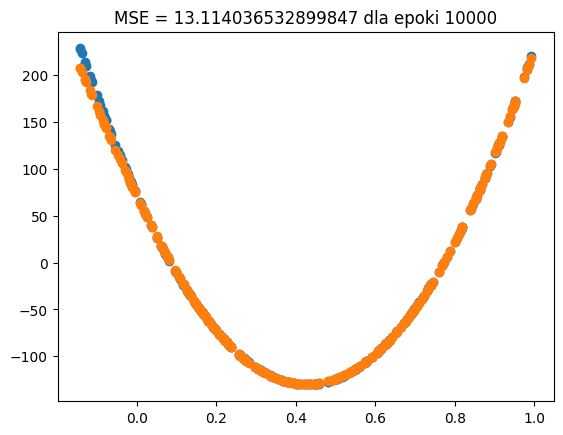

Epoch 10100, Training Loss: 0.00000094, test MSE: 13.08471541497684
Epoch 10200, Training Loss: 0.00000094, test MSE: 12.98797908821536
Epoch 10300, Training Loss: 0.00000093, test MSE: 12.991764673230694
Epoch 10400, Training Loss: 0.00000094, test MSE: 12.870832678420632
Epoch 10500, Training Loss: 0.00000093, test MSE: 12.903110311766016
Epoch 10600, Training Loss: 0.00000093, test MSE: 12.914106900863201
Epoch 10700, Training Loss: 0.00000092, test MSE: 12.840582553493142
Epoch 10800, Training Loss: 0.00000092, test MSE: 12.756441743769308
Epoch 10900, Training Loss: 0.00000092, test MSE: 12.724750059303396
Epoch 11000, Training Loss: 0.00000091, test MSE: 12.741882918995756
Epoch 11100, Training Loss: 0.00000091, test MSE: 12.687959070599248
Epoch 11200, Training Loss: 0.00000091, test MSE: 12.640339534081306
Epoch 11300, Training Loss: 0.00000091, test MSE: 12.670442476445624
Epoch 11400, Training Loss: 0.00000090, test MSE: 12.612990718415146
Epoch 11500, Training Loss: 0.000000

KeyboardInterrupt: 

In [231]:
nn = NeuralNetwork(layers=[1,27,27,1], activation='tanh', beta=0.9, weights_initialize='Xavier')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.02, batch_size=256, epochs=60000, mse_threshold=1.2)


## RMS

### Try 1 MSE = 1.1

Selected optimisation method: RMSProp
Epoch 0, Training Loss: 0.18860690, test MSE: 19119.529723985965


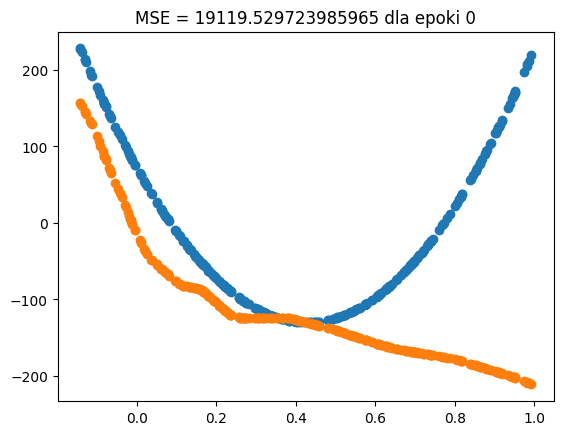

Epoch 100, Training Loss: 0.00828608, test MSE: 1351.3258115561391
Epoch 200, Training Loss: 0.00179448, test MSE: 339.8547161134667
Epoch 300, Training Loss: 0.00045670, test MSE: 117.03345993823368
Epoch 400, Training Loss: 0.00018559, test MSE: 47.94489511786618
Epoch 500, Training Loss: 0.00013447, test MSE: 24.64998906137606
Epoch 600, Training Loss: 0.00012730, test MSE: 19.641870009627844
Epoch 700, Training Loss: 0.00005252, test MSE: 7.359679405813267
Epoch 800, Training Loss: 0.00004005, test MSE: 6.156912441775527
Epoch 900, Training Loss: 0.00003269, test MSE: 5.040647987755673
Epoch 1000, Training Loss: 0.00002627, test MSE: 4.190552630046948
Epoch 1100, Training Loss: 0.00002054, test MSE: 3.2693736574743357
Epoch 1200, Training Loss: 0.00002650, test MSE: 4.025980069455453
Epoch 1300, Training Loss: 0.00002263, test MSE: 3.6688495139553696
Epoch 1400, Training Loss: 0.00002614, test MSE: 4.413574991234432
Epoch 1500, Training Loss: 0.00000582, test MSE: 1.681765702871933

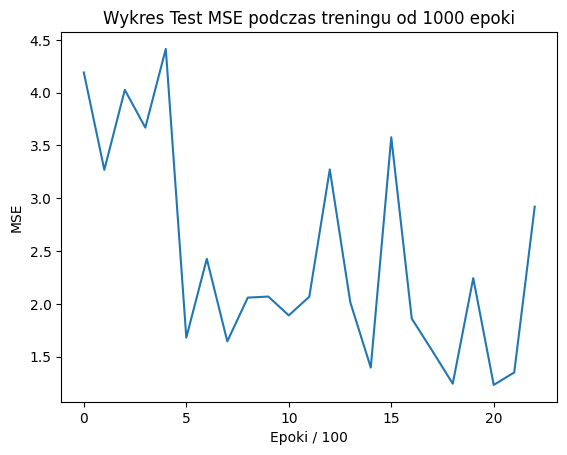

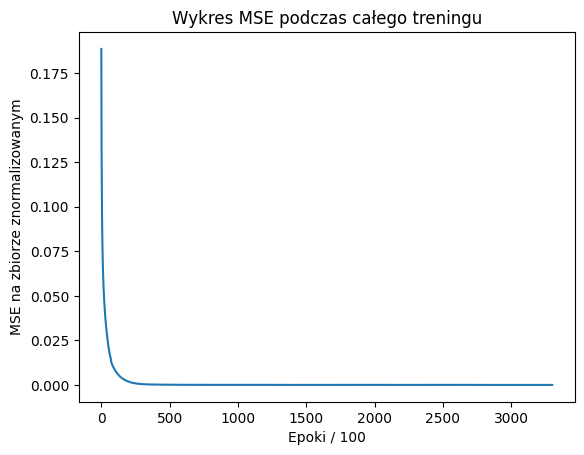

In [241]:
nn = NeuralNetwork(layers=[1,30,29,1], activation='relu', optimisation='rms', rms_decay=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0001, batch_size=256, epochs=60000, mse_threshold=1.2)


### Try 2

Selected optimisation method: RMSProp
Epoch 0, Training Loss: 0.27340911, test MSE: 33282.0129317906


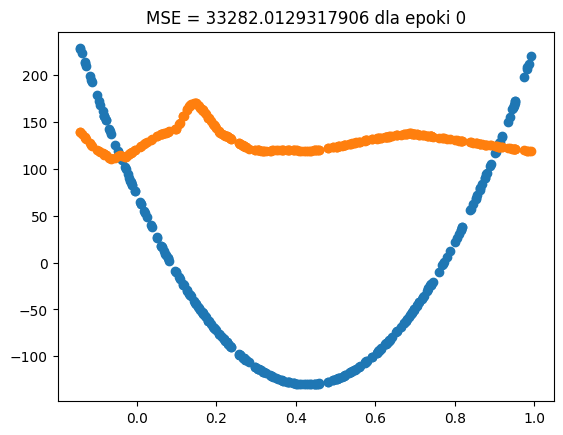

Epoch 100, Training Loss: 0.05533014, test MSE: 7586.720805744313
Epoch 200, Training Loss: 0.01866364, test MSE: 3126.346029680921
Epoch 300, Training Loss: 0.00685271, test MSE: 1319.163410703444
Epoch 400, Training Loss: 0.00306099, test MSE: 635.3876737304802
Epoch 500, Training Loss: 0.00145218, test MSE: 310.6703764771631
Epoch 600, Training Loss: 0.00071369, test MSE: 120.81126455486707
Epoch 700, Training Loss: 0.00040276, test MSE: 74.80802779478581
Epoch 800, Training Loss: 0.00025808, test MSE: 60.931468149192646
Epoch 900, Training Loss: 0.00016204, test MSE: 52.752323368717505
Epoch 1000, Training Loss: 0.00011053, test MSE: 47.65479612569173
Epoch 1100, Training Loss: 0.00011838, test MSE: 49.95331172566643
Epoch 1200, Training Loss: 0.00007318, test MSE: 42.05745562309974
Epoch 1300, Training Loss: 0.00005985, test MSE: 39.319980672581586
Epoch 1400, Training Loss: 0.00005202, test MSE: 38.48770524420626
Epoch 1500, Training Loss: 0.00004631, test MSE: 38.3835346369627
E

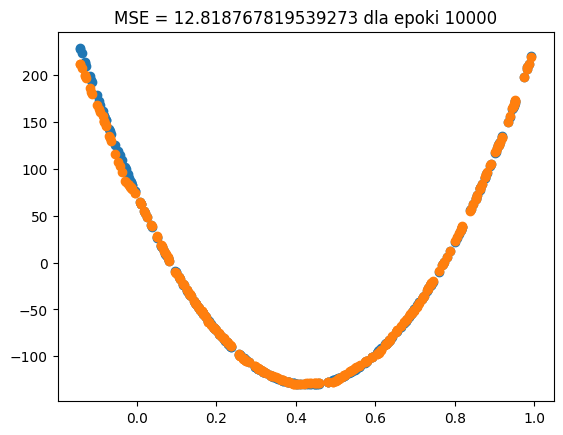

Epoch 10100, Training Loss: 0.00000326, test MSE: 12.911533568076601
Epoch 10200, Training Loss: 0.00001296, test MSE: 12.90817318782421
Epoch 10300, Training Loss: 0.00000836, test MSE: 12.244044731945145
Epoch 10400, Training Loss: 0.00000517, test MSE: 11.889656893687333
Epoch 10500, Training Loss: 0.00002346, test MSE: 15.125405592404428
Epoch 10600, Training Loss: 0.00000400, test MSE: 11.884887465216188
Epoch 10700, Training Loss: 0.00001052, test MSE: 12.985069627363936
Epoch 10800, Training Loss: 0.00001635, test MSE: 13.237930733276702
Epoch 10900, Training Loss: 0.00000786, test MSE: 10.62026124072847
Epoch 11000, Training Loss: 0.00000343, test MSE: 10.953105761471083
Epoch 11100, Training Loss: 0.00001780, test MSE: 11.029531443322725
Epoch 11200, Training Loss: 0.00001914, test MSE: 12.368278152889221
Epoch 11300, Training Loss: 0.00000833, test MSE: 10.2140213876519
Epoch 11400, Training Loss: 0.00000803, test MSE: 9.919939202605741
Epoch 11500, Training Loss: 0.00000827,

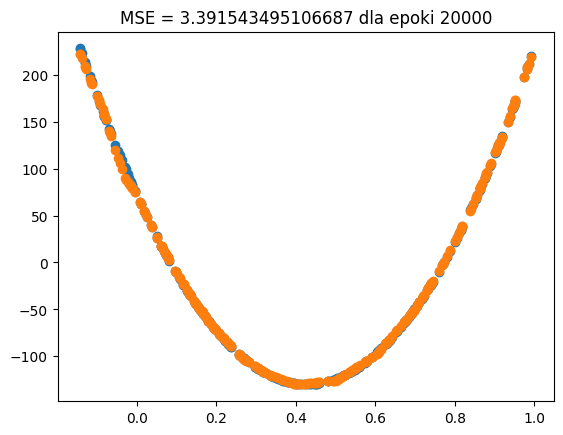

Epoch 20100, Training Loss: 0.00000441, test MSE: 3.8642452874600144
Epoch 20200, Training Loss: 0.00000888, test MSE: 3.833575525373596
Epoch 20300, Training Loss: 0.00000415, test MSE: 3.434951544588285
Epoch 20400, Training Loss: 0.00000675, test MSE: 3.610556654269126
Epoch 20500, Training Loss: 0.00000573, test MSE: 3.9875334826912545
Epoch 20600, Training Loss: 0.00000478, test MSE: 3.8921857786138854
Epoch 20700, Training Loss: 0.00000400, test MSE: 3.417269150240604
Epoch 20800, Training Loss: 0.00000567, test MSE: 3.940833664307347
Epoch 20900, Training Loss: 0.00000574, test MSE: 3.968602076677549
Epoch 21000, Training Loss: 0.00000614, test MSE: 3.954145402649524
Epoch 21100, Training Loss: 0.00000485, test MSE: 3.789876160433661
Epoch 21200, Training Loss: 0.00000560, test MSE: 3.856379645533458
Epoch 21300, Training Loss: 0.00000563, test MSE: 3.4658742373804414
Epoch 21400, Training Loss: 0.00000817, test MSE: 4.259001577764218
Epoch 21500, Training Loss: 0.00000750, test

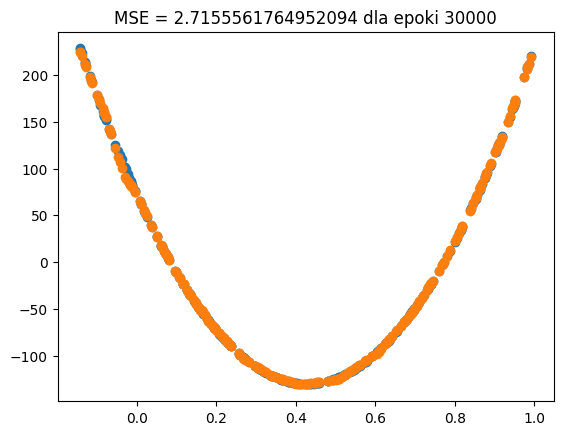

Epoch 30100, Training Loss: 0.00000869, test MSE: 3.683183178513363
Epoch 30200, Training Loss: 0.00001082, test MSE: 3.5076663835300343
Epoch 30300, Training Loss: 0.00000425, test MSE: 2.8649347835191445
Epoch 30400, Training Loss: 0.00001020, test MSE: 3.9343997868815572
Epoch 30500, Training Loss: 0.00001130, test MSE: 4.0361569980976215
Epoch 30600, Training Loss: 0.00000450, test MSE: 2.870575361171943
Epoch 30700, Training Loss: 0.00000219, test MSE: 2.695696925879566
Epoch 30800, Training Loss: 0.00000703, test MSE: 3.466429038375761
Epoch 30900, Training Loss: 0.00002375, test MSE: 5.472428834672402
Epoch 31000, Training Loss: 0.00000436, test MSE: 3.108075037919225
Epoch 31100, Training Loss: 0.00000366, test MSE: 2.971228536988512
Epoch 31200, Training Loss: 0.00000764, test MSE: 3.507169872187719
Epoch 31300, Training Loss: 0.00000509, test MSE: 2.9150964866374522
Epoch 31400, Training Loss: 0.00000242, test MSE: 2.6827821121178
Epoch 31500, Training Loss: 0.00000234, test 

KeyboardInterrupt: 

In [259]:
nn = NeuralNetwork(layers=[1,30,35,1], activation='relu', optimisation='rms', rms_decay=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.00005, batch_size=256, epochs=60000, mse_threshold=1)


# Steps large

In [442]:
train_df = pd.read_csv('data/steps-large-training.csv')
test_df = pd.read_csv('data/steps-large-test.csv')

X_train, Y_train=train_df['x'].to_numpy().reshape(-1,1), train_df['y'].to_numpy().reshape(-1,1)
X_test, Y_test=test_df['x'].to_numpy().reshape(-1,1), test_df['y'].to_numpy().reshape(-1,1)
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_normalized = x_scaler.fit_transform(X_train.reshape(-1, 1))
Y_train_normalized = y_scaler.fit_transform(Y_train.reshape(-1, 1))

X_test_normalized = x_scaler.transform(X_test.reshape(-1,1))
Y_test_normalized = y_scaler.transform(Y_test.reshape(-1,1))

## Momentum

### Try 1 momentum

Selected optimisation method: Momentum
Epoch 0, Training Loss: 0.15317711, test MSE: 8763.688030333704


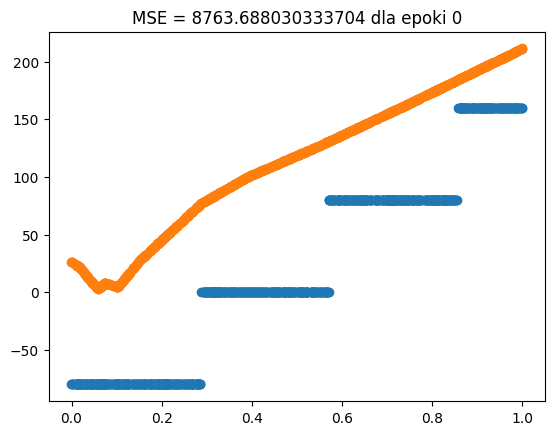

Epoch 100, Training Loss: 0.00710749, test MSE: 414.4949107755571
Epoch 200, Training Loss: 0.00683778, test MSE: 397.53967342729663
Epoch 300, Training Loss: 0.00666110, test MSE: 384.47574561991553
Epoch 400, Training Loss: 0.00644585, test MSE: 372.2210026185699
Epoch 500, Training Loss: 0.00631185, test MSE: 364.1503545583242
Epoch 600, Training Loss: 0.00619305, test MSE: 355.32189888838957
Epoch 700, Training Loss: 0.00608769, test MSE: 348.6128199707342
Epoch 800, Training Loss: 0.00600097, test MSE: 343.4933690276784
Epoch 900, Training Loss: 0.00592778, test MSE: 338.7631820167217
Epoch 1000, Training Loss: 0.00587774, test MSE: 335.7584914373803


KeyboardInterrupt: 

In [470]:
nn = NeuralNetwork(layers=[1,10,15, 1], activation='relu',optimisation='momentum',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.001, batch_size=512, epochs=60000, mse_threshold=3)


## RMS

### Try 1 : MSE = 2.76

Selected optimisation method: RMSProp
Epoch 0, Training Loss: 0.00951872, test MSE: 556.749349502155


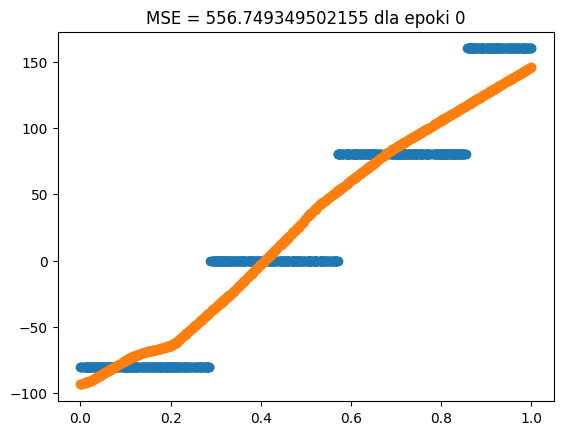

Epoch 100, Training Loss: 0.00503168, test MSE: 286.3506359373363
Epoch 200, Training Loss: 0.00389584, test MSE: 223.21469245464124
Epoch 300, Training Loss: 0.00263800, test MSE: 158.2603225473658
Epoch 400, Training Loss: 0.00248928, test MSE: 151.10978127118065
Epoch 500, Training Loss: 0.00241433, test MSE: 144.10718530312238
Epoch 600, Training Loss: 0.00235535, test MSE: 141.5964900377464
Epoch 700, Training Loss: 0.00226493, test MSE: 143.02482847514537
Epoch 800, Training Loss: 0.00234034, test MSE: 147.0773250765769
Epoch 900, Training Loss: 0.00214909, test MSE: 135.00120515498017
Epoch 1000, Training Loss: 0.00201125, test MSE: 123.83555024379146
Epoch 1100, Training Loss: 0.00200066, test MSE: 127.29511029370394
Epoch 1200, Training Loss: 0.00202903, test MSE: 124.53071732837856
Epoch 1300, Training Loss: 0.00189559, test MSE: 118.53954952093322
Epoch 1400, Training Loss: 0.00352862, test MSE: 202.8003096109805
Epoch 1500, Training Loss: 0.00172065, test MSE: 108.792309941

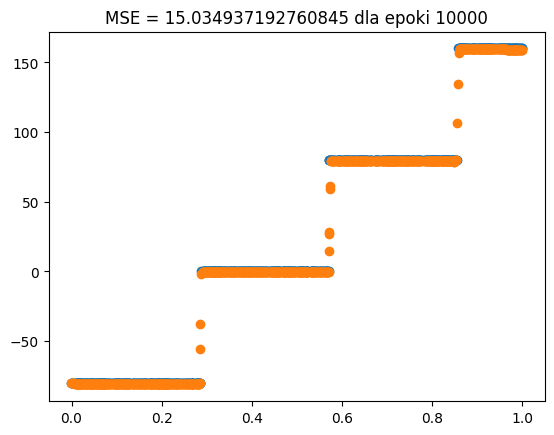

Epoch 10100, Training Loss: 0.00014596, test MSE: 7.256000059485746
Epoch 10200, Training Loss: 0.00074393, test MSE: 39.98979580296272
Epoch 10300, Training Loss: 0.00022690, test MSE: 11.732263669457106
Epoch 10400, Training Loss: 0.00014948, test MSE: 4.50029808203496
Epoch 10500, Training Loss: 0.00015224, test MSE: 4.73793235481417
Epoch 10600, Training Loss: 0.00066404, test MSE: 15.7072549438711
Epoch 10700, Training Loss: 0.00035355, test MSE: 12.581920909783278
Epoch 10800, Training Loss: 0.00014812, test MSE: 9.47689224590178
Epoch 10900, Training Loss: 0.00013328, test MSE: 5.1154287134981695
Epoch 11000, Training Loss: 0.00031349, test MSE: 17.09034735340406
Epoch 11100, Training Loss: 0.00027073, test MSE: 17.91715030685622
Epoch 11200, Training Loss: 0.00024588, test MSE: 10.260350250284363
Epoch 11300, Training Loss: 0.00025186, test MSE: 11.256383930759307
Epoch 11400, Training Loss: 0.00012426, test MSE: 6.8064553659110825
Epoch 11500, Training Loss: 0.00024484, test M

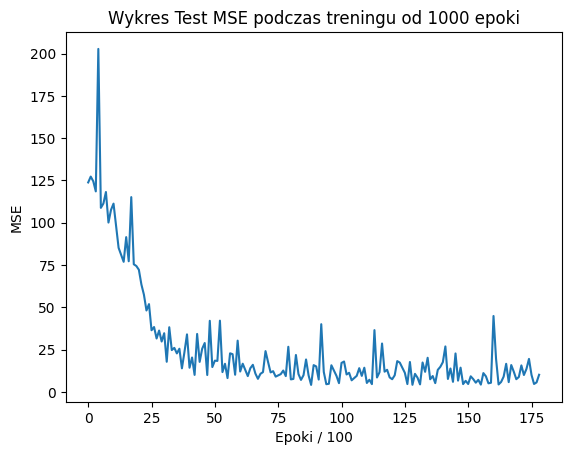

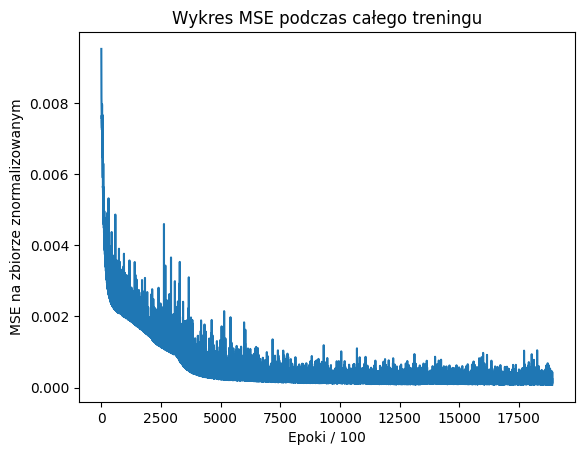

In [314]:
nn = NeuralNetwork(layers=[1,25,20, 1], activation='relu',optimisation='rms',rms_decay=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.0008, batch_size=512, epochs=60000, mse_threshold=3)


# Multimodal Large

In [431]:
train_df = pd.read_csv('data/multimodal-large-training.csv')
test_df = pd.read_csv('data/multimodal-large-test.csv')

X_train, Y_train=train_df['x'].to_numpy().reshape(-1,1), train_df['y'].to_numpy().reshape(-1,1)
X_test, Y_test=test_df['x'].to_numpy().reshape(-1,1), test_df['y'].to_numpy().reshape(-1,1)
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_normalized = x_scaler.fit_transform(X_train.reshape(-1, 1))
Y_train_normalized = y_scaler.fit_transform(Y_train.reshape(-1, 1))

X_test_normalized = x_scaler.transform(X_test.reshape(-1,1))
Y_test_normalized = y_scaler.transform(Y_test.reshape(-1,1))

## Momentum

### Try 1 : mse = 8.43

Selected optimisation method: Momentum
Epoch 0, Training Loss: 0.31571218, test MSE: 12506.60628759154


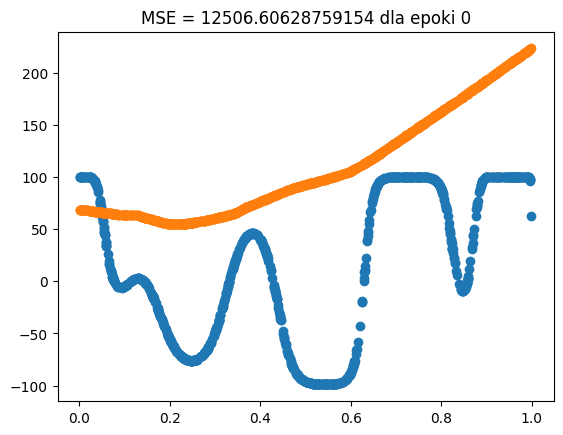

Epoch 100, Training Loss: 0.00469611, test MSE: 195.380022348416
Epoch 200, Training Loss: 0.00296211, test MSE: 127.32918111159188
Epoch 300, Training Loss: 0.00051353, test MSE: 17.907981341138477
Epoch 400, Training Loss: 0.00032383, test MSE: 9.533907516705666
Epoch 500, Training Loss: 0.00029646, test MSE: 8.430451662704696
TEST MSE ACHIEVED: 8.430451662704696, epoch500
TRAIN DURATION: 21.041881322860718
TRAIN DURATION: 21.041881322860718


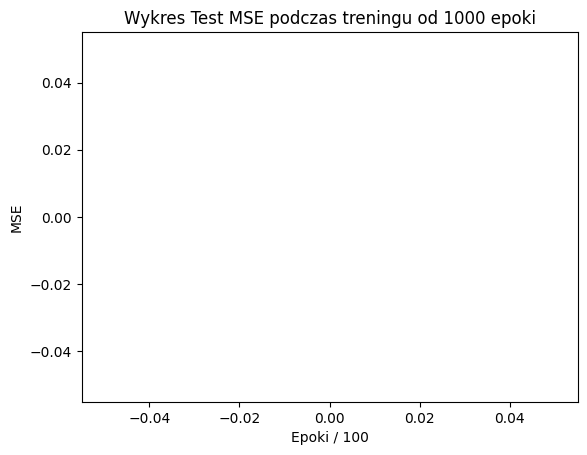

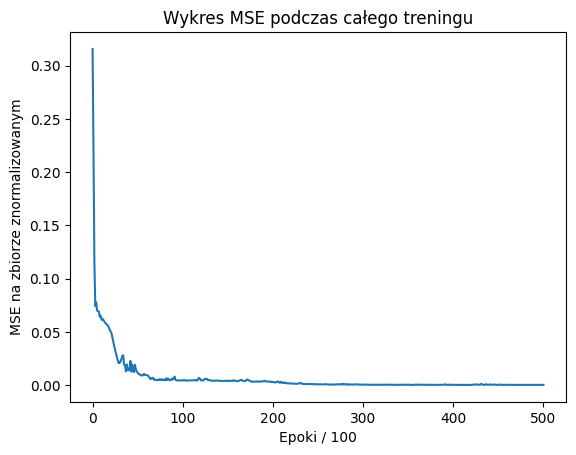

In [436]:
nn = NeuralNetwork(layers=[1,55,55,55, 1], activation='relu',optimisation='momentum',beta=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.01, batch_size=512, epochs=60000, mse_threshold=9)


## RMS

### Try 1 : mse =2.45

Selected optimisation method: RMSProp
Epoch 0, Training Loss: 0.06449802, test MSE: 2475.7429859752933


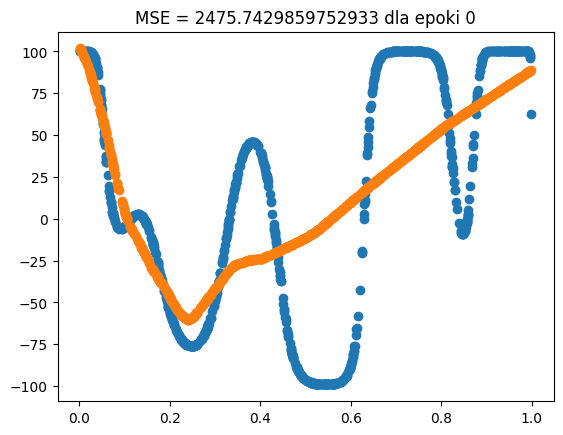

Epoch 100, Training Loss: 0.00567856, test MSE: 244.680855306083
Epoch 200, Training Loss: 0.00139433, test MSE: 48.48901208465241
Epoch 300, Training Loss: 0.00095953, test MSE: 29.585636843351903
Epoch 400, Training Loss: 0.00330202, test MSE: 103.10281902893738
Epoch 500, Training Loss: 0.00050381, test MSE: 15.424670967288035
Epoch 600, Training Loss: 0.00110303, test MSE: 36.87059735111766
Epoch 700, Training Loss: 0.00015025, test MSE: 2.457100464862677
TEST MSE ACHIEVED: 2.457100464862677, epoch700
TRAIN DURATION: 28.729249477386475
TRAIN DURATION: 28.729249477386475


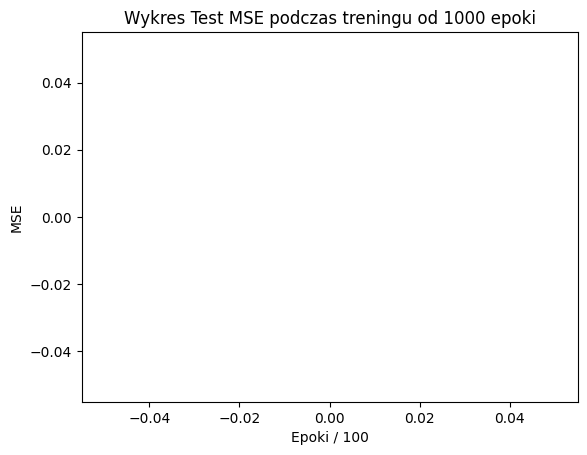

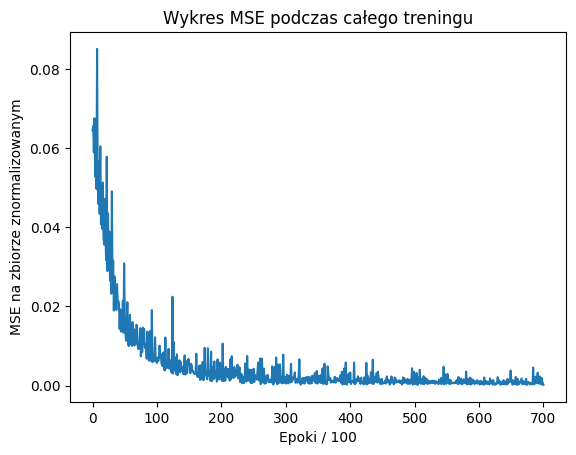

In [441]:
nn = NeuralNetwork(layers=[1,55,55,55, 1], activation='relu',optimisation='rms',rms_decay=0.99, weights_initialize='He')
nn.train(X_train_normalized, Y_train_normalized, X_test_normalized, Y_test, y_scaler, learning_rate=0.001, batch_size=512, epochs=60000, mse_threshold=9)
